# Importing Packages

In [10]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

import smote_variants as sv
import imbalanced_databases as imbd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

from imblearn.under_sampling import CondensedNearestNeighbour, NearMiss, OneSidedSelection, NeighbourhoodCleaningRule, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, KMeansSMOTE
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier

%reload_ext autoreload
%autoreload 2
from utils import *


2021-06-29 14:31:53,074:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


# Importing Datasets

In [2]:
df = pd.read_excel("data/default of credit card clients.xls")
new_header = df.iloc[0]
df = df[1:] 
df.columns = new_header
df = df.rename(columns={"default payment next month": "default"}) 
df = df.drop(columns=["ID"], axis=1)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df = df.rename(columns={"PAY_0": "behind1", 
                        "PAY_2": "behind2", 
                        "PAY_3": "behind3", 
                        "PAY_4": "behind4",
                        "PAY_5": "behind5", 
                        "PAY_6": "behind6", 
                        "BILL_AMT1": "billed1", 
                        "BILL_AMT2": "billed2", 
                        "BILL_AMT3": "billed3", 
                        "BILL_AMT4": "billed4", 
                        "BILL_AMT5": "billed5", 
                        "BILL_AMT6": "billed6", 
                        "PAY_AMT1": "paid1", 
                        "PAY_AMT2": "paid2", 
                        "PAY_AMT3": "paid3", 
                        "PAY_AMT4": "paid4", 
                        "PAY_AMT5": "paid5", 
                        "PAY_AMT6": "paid6",
                        "SEX": "gender",
                        "EDUCATION": "education",
                        "MARRIAGE": "marriage",
                        "AGE": "age",
                        "LIMIT_BAL": "limit"})

In [4]:
df.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6,default
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
X = df.drop(["default"], axis=1)
y = df["default"]
y = y.astype('int')
# split the full data 80:20 into training:validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)

In [6]:
X_train = train.drop(["default"], axis=1)
y_train = train["default"]
X_valid = val.drop(["default"], axis=1)
y_valid = val["default"]

# Target Variable Visualization

In [7]:
#Supress default INFO logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

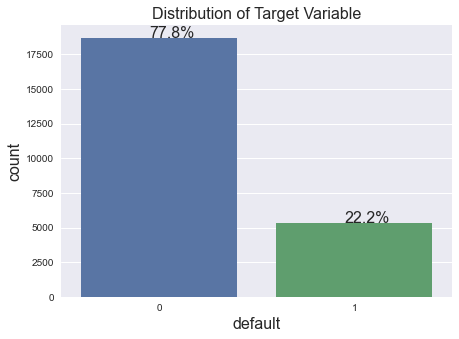

In [8]:
# create visualization for target variable distribution
def barplot(df, xlabel, ylabel, title):
    plt.figure(figsize = (7,5))
    ax = sns.countplot(x = xlabel, data = df)
    plt.title(title, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    total = len(df.default)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 16)
    plt.show()

barplot(train, 'default', 'count', 'Distribution of Target Variable')

In [9]:
plt.savefig("images/default_distribution.png")

<Figure size 576x396 with 0 Axes>

# Standardize Datasets

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_ss = scaler.transform(X_train)
X_valid_ss = scaler.transform(X_valid)

# Using Best Model

In [8]:
gbc = GradientBoostingClassifier(random_state=42).fit(X_train_ss, y_train)
y_pred = gbc.predict(X_valid_ss)
get_metrics(X_valid_ss, y_valid, y_pred, gbc)

Accuracy Score:  0.8198333333333333
F1 Score:  0.46245648930880157
ROC-AUC Score:  0.7827684813417417
Recall Score:  0.3541507996953541
Precision Score:  0.666189111747851
PR-AUC Score:  0.5491782881180063


# Dummy Classifier

In [12]:
# separate minority and majority classes
majority = train[train.default==0]
minority = train[train.default==1]

#baseline counts
counter = Counter(y_train)
print("Baseline: ", counter)

Baseline:  Counter({0: 18677, 1: 5323})


In [13]:
dc = DummyClassifier(strategy='most_frequent').fit(X_train_ss, y_train)
y_pred_dc = dc.predict(X_valid_ss)
get_metrics(X_valid_ss, y_valid, y_pred_dc, dc)

Accuracy Score:  0.7811666666666667
F1 Score:  0.0
ROC-AUC Score:  0.5
Recall Score:  0.0
Precision Score:  0.0
PR-AUC Score:  0.21883333333333332


# Ensemble Methods

## Balanced Bagging Classifier



In [15]:
bbc = BalancedBaggingClassifier(n_estimators=50, random_state=42).fit(X_train_ss, y_train)
y_pred_bbc = bbc.predict(X_valid_ss)
get_metrics(X_valid_ss, y_valid, y_pred_bbc, bbc)

Accuracy Score:  0.7778333333333334
F1 Score:  0.5189462287982678
ROC-AUC Score:  0.7617891427586244
Recall Score:  0.5476009139375476
Precision Score:  0.49314128943758573
PR-AUC Score:  0.5141686465893252


## Balanced Random Forest Classifier



In [17]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42).fit(X_train_ss, y_train)
y_pred_brf = brf.predict(X_valid_ss)
get_metrics(X_valid_ss, y_valid, y_pred_brf, brf)

Accuracy Score:  0.7443333333333333
F1 Score:  0.5170025188916877
ROC-AUC Score:  0.7714385091657809
Recall Score:  0.6252856054836253
Precision Score:  0.4406870638754697
PR-AUC Score:  0.525055734654262


## RUSBoost Classifier



In [18]:
rbc = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R', random_state=42).fit(X_train_ss, y_train)
y_pred_rbc = rbc.predict(X_valid_ss)
get_metric(X_valid_ss, y_valid, y_pred_rbc, rbc)

Accuracy Score:  0.7523333333333333
F1 Score:  0.5212628865979382
ROC-AUC Score:  0.7660350589719161
Recall Score:  0.6161462300076161
Precision Score:  0.4517029592406477
PR-AUC Score:  0.5181164037053775


## Easy Ensemble Classifier


In [19]:
eec = EasyEnsembleClassifier(random_state=42).fit(X_train_ss, y_train) 
y_pred_eec = eec.predict(X_valid_ss)
get_metrics(X_valid_ss, y_valid, y_pred_eec, eec)

Accuracy Score:  0.7591666666666667
F1 Score:  0.5291625936787228
ROC-AUC Score:  0.7768365157731575
Recall Score:  0.6184310738766184
Precision Score:  0.4624145785876993
PR-AUC Score:  0.5327657543186086


## Ensemble Metrics Dataframe


In [61]:
data = {'Accuracy': [accuracy_score(y_valid, y_pred),
                     accuracy_score(y_valid, y_pred_bbc),
                     accuracy_score(y_valid, y_pred_brf),
                     accuracy_score(y_valid, y_pred_rbc),
                     accuracy_score(y_valid, y_pred_eec)],
        'F1 Score': [f1_score(y_valid, y_pred),
                     f1_score(y_valid, y_pred_bbc),
                     f1_score(y_valid, y_pred_brf),
                     f1_score(y_valid, y_pred_rbc),
                     f1_score(y_valid, y_pred_eec)],
        'ROC-AUC Score': [auc(X_valid_ss, y_valid, gbc),
                          auc(X_valid_ss, y_valid, bbc),
                          auc(X_valid_ss, y_valid, brf),
                          auc(X_valid_ss, y_valid, rbc),
                          auc(X_valid_ss, y_valid, eec)],
        'PR-AUC Score': [aps(X_valid_ss, y_valid, gbc),
                         aps(X_valid_ss, y_valid, bbc),
                         aps(X_valid_ss, y_valid, brf),
                         aps(X_valid_ss, y_valid, rbc),
                         aps(X_valid_ss, y_valid, eec)]}

scores = pd.DataFrame(data=data, index = ['Gradient Boosting Classifier',
                                          'Balanced Bagging Classifier',
                                          'Balanced Random Forest Classifier',
                                          'RUBoost Classifier',
                                          'Easy Ensemble Classifier'])

scores

,Accuracy,F1 Score,ROC-AUC Score,PR-AUC Score
Gradient Boosting Classifier,0.819833,0.462456,0.769115,0.527357
Balanced Bagging Classifier,0.777833,0.518946,0.761789,0.514169
Balanced Random Forest Classifier,0.744333,0.517003,0.771439,0.525056
RUBoost Classifier,0.752333,0.521263,0.766035,0.518116
Easy Ensemble Classifier,0.759167,0.529163,0.776837,0.532766


In [56]:
scores.to_csv("data/scores.csv")

# Undersampling Methods


## TomekLinks



In [21]:
tl = TomekLinks()
run_resampling(X_train_ss, y_train, X_valid_ss, y_valid, tl, gbc)

Training Count:  Counter({0: 17259, 1: 5323})
Accuracy Score:  0.8185
F1 Score:  0.48413074372335385
ROC-AUC Score:  0.7815206813225348
Recall Score:  0.38918507235338917
Precision Score:  0.6403508771929824
PR-AUC Score:  0.5469931467520384


In [22]:
X_train_tl, y_train_tl = tl.fit_sample(X_train_ss, y_train)
tlm = gbc.fit(X_train_tl, y_train_tl)
y_pred_tl = tlm.predict(X_valid_ss)

## Edited Nearest Neighbours



In [23]:
enn = EditedNearestNeighbours()
run_resampling(X_train_ss, y_train, X_valid_ss, y_valid, enn, gbc)

Training Count:  Counter({0: 11382, 1: 5323})
Accuracy Score:  0.7893333333333333
F1 Score:  0.5416968817984046
ROC-AUC Score:  0.7800101266958193
Recall Score:  0.5689261233815689
Precision Score:  0.5169550173010381
PR-AUC Score:  0.5397934293984156


In [24]:
X_train_enn, y_train_enn = enn.fit_sample(X_train_ss, y_train)
ennm = gbc.fit(X_train_enn, y_train_enn)
y_pred_enn = ennm.predict(X_valid_ss)

## Near Miss

In [11]:
ns = NearMiss(version=1, n_neighbors=3)
run_resampling(X_train_ss, y_train, X_valid_ss, y_valid, ns, gbc)

Training Count:  Counter({0: 5323, 1: 5323})
Accuracy Score:  0.49333333333333335
F1 Score:  0.39345570630486826
ROC-AUC Score:  0.6060651953166957
Recall Score:  0.7509520182787509
Precision Score:  0.26655852933225194
PR-AUC Score:  0.26240354411804023


In [26]:
X_train_ns, y_train_ns = ns.fit_sample(X_train_ss, y_train)
nsm = gbc.fit(X_train_ns, y_train_ns)
y_pred_ns = nsm.predict(X_valid_ss)

## One Sided Selection

In [29]:
oss = OneSidedSelection(n_neighbors=1, n_seeds_S=200)
run_resampling(X_train_ss, y_train, X_valid_ss, y_valid, oss, gbc)

Training Count:  Counter({0: 15696, 1: 5323})
Accuracy Score:  0.8193333333333334
F1 Score:  0.4847908745247148
ROC-AUC Score:  0.7801089237282035
Recall Score:  0.38842345773038844
Precision Score:  0.6447534766118836
PR-AUC Score:  0.5421743004221333


In [30]:
X_train_oss, y_train_oss = oss.fit_sample(X_train_ss, y_train)
ossm = gbc.fit(X_train_oss, y_train_oss)
y_pred_oss = ossm.predict(X_valid_ss)

## Undersampling Metrics Dataframe

In [57]:
data = {'Accuracy': [accuracy_score(y_valid, y_pred_tl),
                     accuracy_score(y_valid, y_pred_enn),
                     accuracy_score(y_valid, y_pred_ns),
                     accuracy_score(y_valid, y_pred_oss)],
        'F1 Score': [f1_score(y_valid, y_pred_tl),
                     f1_score(y_valid, y_pred_enn),
                     f1_score(y_valid, y_pred_ns),
                     f1_score(y_valid, y_pred_oss)],
        'ROC-AUC Score': [auc(X_valid_ss, y_valid, tlm),
                          auc(X_valid_ss, y_valid, ennm),
                          auc(X_valid_ss, y_valid, nsm),
                          auc(X_valid_ss, y_valid, ossm)],
        'PR-AUC Score': [aps(X_valid_ss, y_valid, tlm),
                         aps(X_valid_ss, y_valid, ennm),
                         aps(X_valid_ss, y_valid, nsm),
                         aps(X_valid_ss, y_valid, ossm)]}

scores2 = pd.DataFrame(data=data, index = ['Tomek Links',
                                           'Edited Nearest Neighbour',
                                           'Near Miss',
                                           'One Sided Selection'])

scores2

,Accuracy,F1 Score,ROC-AUC Score,PR-AUC Score
Tomek Links,0.818500,0.484131,0.769115,0.527357
Edited Nearest Neighbour,0.789333,0.541697,0.769115,0.527357
Near Miss,0.493333,0.393456,0.769115,0.527357
One Sided Selection,0.819167,0.486026,0.769115,0.527357


In [58]:
scores2.to_csv("data/scores2.csv")

# Oversampling Methods


## SMOTE

In [34]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
run_resampling(X_train_ss, y_train, X_valid_ss, y_valid, sm, gbc)

Training Count:  Counter({0: 18677, 1: 18677})
Accuracy Score:  0.7946666666666666
F1 Score:  0.5202492211838006
ROC-AUC Score:  0.7689508713882007
Recall Score:  0.5087585681645087
Precision Score:  0.5322709163346614
PR-AUC Score:  0.5294679952321515


In [35]:
X_train_sm, y_train_sm = sm.fit_sample(X_train_ss, y_train)
smm = gbc.fit(X_train_sm, y_train_sm)
y_pred_sm = smm.predict(X_valid_ss)

## SVMSMOTE

- Variant of SMOTE algorithm which uses an SVM algorithm to detect sample for generating new synthetic samples

In [36]:
svmsm = SVMSMOTE()
run_resampling(X_train_ss, y_train, X_valid_ss, y_valid, svmsm, gbc)

Training Count:  Counter({0: 18677, 1: 18677})
Accuracy Score:  0.7908333333333334
F1 Score:  0.5297864368677407
ROC-AUC Score:  0.772568418976115
Recall Score:  0.5384615384615384
Precision Score:  0.5213864306784661
PR-AUC Score:  0.5265412967988327


In [37]:
X_train_svm, y_train_svm = svmsm.fit_sample(X_train_ss, y_train)
svmsmote = gbc.fit(X_train_svm, y_train_svm)
y_pred_svmsm = svmsmote.predict(X_valid_ss)

## ADASYN

- Oversample using Adaptive Synthetic (ADASYN) algorithm

In [42]:
adsn = ADASYN()
run_resampling(X_train_ss, y_train, X_valid_ss, y_valid, adsn, gbc)

Training Count:  Counter({0: 18677, 1: 18190})
Accuracy Score:  0.7851666666666667
F1 Score:  0.5044213763936947
ROC-AUC Score:  0.7611706050879498
Recall Score:  0.49961919268849964
Precision Score:  0.5093167701863354
PR-AUC Score:  0.526363676038874


In [43]:
X_train_adsn, y_train_adsn = adsn.fit_sample(X_train_ss, y_train)
adsnm = gbc.fit(X_train_adsn, y_train_adsn)
y_pred_adsnm = adsnm.predict(X_valid_ss)

## Oversampling Metrics Dataframe

In [44]:
data = {'Accuracy': [accuracy_score(y_valid, y_pred_sm),
                     accuracy_score(y_valid, y_pred_svmsm),
                     accuracy_score(y_valid, y_pred_adsnm)],
        'F1 Score': [f1_score(y_valid, y_pred_sm),
                     f1_score(y_valid, y_pred_svmsm),
                     f1_score(y_valid, y_pred_adsnm)],
        'ROC-AUC Score': [auc(X_valid_ss, y_valid, smm),
                          auc(X_valid_ss, y_valid, svmsmote),
                          auc(X_valid_ss, y_valid, adsnm)],
        'PR-AUC Score': [aps(X_valid_ss, y_valid, smm),
                         aps(X_valid_ss, y_valid, svmsmote),
                         aps(X_valid_ss, y_valid, adsnm)]}

scores3 = pd.DataFrame(data=data, index = ['SMOTE',
                                           'SVMSMOTE',
                                           'ADASYN'])

scores3

,Accuracy,F1 Score,ROC-AUC Score,PR-AUC Score
SMOTE,0.794667,0.520249,0.76353,0.523697
SVMSMOTE,0.794167,0.524817,0.76353,0.523697
ADASYN,0.786500,0.505596,0.76353,0.523697


In [45]:
scores3.to_csv("data/scores3.csv")

# Combined Methods

## SMOTE-Tomek

- oversampling using SMOTE and cleaning using Tomek Links

In [46]:
smtk = SMOTETomek()
run_resampling(X_train_ss, y_train, X_valid_ss, y_valid, smtk, gbc)

Training Count:  Counter({0: 18254, 1: 18254})
Accuracy Score:  0.7918333333333333
F1 Score:  0.517201391573251
ROC-AUC Score:  0.7658645203444702
Recall Score:  0.5095201827875095
Precision Score:  0.5251177394034537
PR-AUC Score:  0.527352648141067


In [47]:
X_train_smt, y_train_smt = smtk.fit_sample(X_train_ss, y_train)
smtkm = gbc.fit(X_train_smt, y_train_smt)
y_pred_smtk = smtkm.predict(X_valid_ss)

## SMOTE-ENN

- Oversampling using SMOTE and cleaning using ENN

In [48]:
smenn = SMOTEENN(sampling_strategy="minority", n_jobs= -1)
run_resampling(X_train_ss, y_train, X_valid_ss, y_valid, smenn, gbc)

Training Count:  Counter({1: 14116, 0: 9713})
Accuracy Score:  0.7353333333333333
F1 Score:  0.5173252279635259
ROC-AUC Score:  0.773236842648339
Recall Score:  0.6481340441736482
Precision Score:  0.430450177035913
PR-AUC Score:  0.5315682901573054


In [49]:
X_train_sme, y_train_sme = smenn.fit_sample(X_train_ss, y_train)
smennm = gbc.fit(X_train_sme, y_train_sme)
y_pred_smenn = smennm.predict(X_valid_ss)

## Combined Metrics Dataframe

In [50]:
data = {'Accuracy': [accuracy_score(y_valid, y_pred_smtk),
                     accuracy_score(y_valid, y_pred_smenn)],
        'F1 Score': [f1_score(y_valid, y_pred_smtk),
                     f1_score(y_valid, y_pred_smenn)],
        'ROC-AUC Score': [auc(X_valid_ss, y_valid, smtkm),
                          auc(X_valid_ss, y_valid, smennm)],
        'PR-AUC Score': [aps(X_valid_ss, y_valid, smtkm),
                         aps(X_valid_ss, y_valid, smennm)]}

scores4 = pd.DataFrame(data=data, index = ['SMOTE-Tomek',
                                           'SMOTE-ENN'])

scores4

,Accuracy,F1 Score,ROC-AUC Score,PR-AUC Score
SMOTE-Tomek,0.7925,0.519119,0.769115,0.527357
SMOTE-ENN,0.7220,0.506509,0.769115,0.527357


In [51]:
scores4.to_csv("data/scores4.csv")

# Metrics Dataframe

In [62]:
scores_comb = pd.concat([scores, scores2, scores3, scores4], axis=0)
scores_comb

,Accuracy,F1 Score,ROC-AUC Score,PR-AUC Score
Gradient Boosting Classifier,0.819833,0.462456,0.769115,0.527357
Balanced Bagging Classifier,0.777833,0.518946,0.761789,0.514169
Balanced Random Forest Classifier,0.744333,0.517003,0.771439,0.525056
RUBoost Classifier,0.752333,0.521263,0.766035,0.518116
Easy Ensemble Classifier,0.759167,0.529163,0.776837,0.532766
Tomek Links,0.818500,0.484131,0.769115,0.527357
Edited Nearest Neighbour,0.789333,0.541697,0.769115,0.527357
Near Miss,0.493333,0.393456,0.769115,0.527357
One Sided Selection,0.819167,0.486026,0.769115,0.527357
SMOTE,0.794667,0.520249,0.763530,0.523697


In [60]:
scores_comb.to_csv('data/imbalanced_scores.csv')